Minimum diffusion EDM(Eular) training / generation code for personal understaning.  
For simplicity  
- data : MNIST with image shape (32, 32, 1)  
- model : simple Unet with time embedding  
- no latent encoder such as VAE (i.e., non latent diffusion)  


failed (not resolved)

https://arxiv.org/pdf/2206.00364

In [1]:
from typing import Tuple, Any
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb

In [39]:
# Data Config
IMG_SHAPE = (1, 32, 32)

# Training Config
EPOCHS = 15
TRAIN_BATCH_SIZE = 64
LR = 1e-4
WEIGHT_DECAY = 1e-2

# Diffusion Config
STEPS = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Data Pereparation

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(IMG_SHAPE[1:]),
        torchvision.transforms.Normalize(0.5, 0.5),
    ]),
    download=True,
)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.25MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([1, 32, 32]) 5


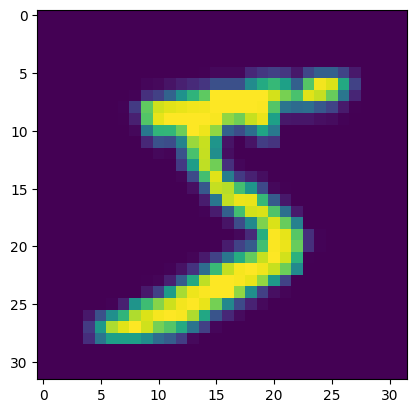

In [4]:
print(train_dataset[0][0].shape, train_dataset[0][1])
plt.imshow(train_dataset[0][0].squeeze().numpy())

## 2. Model

In [5]:
# Time Embedder (borrowed from micro diffusion)

class TimestepEmbedder(nn.Module):
    """Embeds scalar timesteps into vector representations.

    Args:
        hidden_size (int): Size of hidden dimension
        act_layer (Any): Activation layer constructor
        frequency_embedding_size (int, 512): Size of frequency embedding
    """
    def __init__(
        self,
        hidden_size: int,
        act_layer: Any = nn.SiLU,
        frequency_embedding_size: int = 512
    ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            act_layer(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t: torch.Tensor, dim: int, max_period: int = 10000) -> torch.Tensor:
        """Create sinusoidal timestep embeddings."""
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(
                start=0,
                end=half,
                dtype=torch.float32,
                device=t.device
            ) / half
        )
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size).to(self.dtype)
        return self.mlp(t_freq)

    @property
    def dtype(self) -> torch.dtype:
        return next(self.parameters()).dtype

In [6]:
TimestepEmbedder(hidden_size=28*28).eval()(torch.arange(0, 1000)).detach().shape

torch.Size([1000, 784])

In [7]:
def modulate(x: torch.Tensor, shift: torch.Tensor, scale: torch.Tensor) -> torch.Tensor:
    """Applies modulation to input tensor using shift and scale factors."""
    return x * (1 + scale) + shift

In [8]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1, ch_scale = 1):
        super(SimpleUNet, self).__init__()

        # エンコーダ部分
        self.enc1 = self.conv_block(in_channels, 64 // ch_scale)
        self.enc2 = self.conv_block(64 // ch_scale, 128 // ch_scale)
        self.enc3 = self.conv_block(128 // ch_scale, 256 // ch_scale)
        self.enc4 = self.conv_block(256 // ch_scale, 512 // ch_scale)

        # ボトム部分
        self.center = self.conv_block(512 // ch_scale, 1024 // ch_scale)

        # デコーダ部分
        self.upconv4 = self.upconv_block(1024 // ch_scale, 512 // ch_scale)
        self.upconv3 = self.upconv_block(512 // ch_scale, 256 // ch_scale)
        self.upconv2 = self.upconv_block(256 // ch_scale, 128 // ch_scale)
        self.upconv1 = self.upconv_block(128 // ch_scale, 64 // ch_scale)

        # 出力層
        self.final_conv = nn.Conv2d(64 // ch_scale, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return block

    def upconv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # エンコーダ
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        # ボトム部分
        center = self.center(F.max_pool2d(enc4, 2))

        # デコーダ
        up4 = self.upconv4(center)
        up3 = self.upconv3(up4 + enc4)  # skip connection
        up2 = self.upconv2(up3 + enc3)  # skip connection
        up1 = self.upconv1(up2 + enc2)  # skip connection

        # 最終出力
        output = self.final_conv(up1 + enc1)  # skip connection
        return output

In [40]:
class DenoiseModel(torch.nn.Module):
    def __init__(
        self,
        img_shape: Tuple[int, int, int] = IMG_SHAPE,  # (ch, h, w)
    ):
        super().__init__()
        self._img_shape = img_shape
        ch, h, w = img_shape
        self._unet_denoiser = SimpleUNet()
        self._timestep_embedder = TimestepEmbedder(hidden_size=ch*h*w)
        self._adaLN_modulation = nn.Sequential(
            nn.GELU(approximate="tanh"),
            nn.Linear(ch*h*w, 2 * ch*h*w, bias=True),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """Given noisy input image x_t and time t, predict the added noise (x_t - x_t-1).

        Args:
            x (torch.Tensor): input noisy image x_t with shape (bs, ch, h, w)
            t (torch.Tensor): time steps with shape (bs,)

        Returns:
            torch.Tensor: Predicted added noise image (x_t - x_t-1) with shape (bs, ch, h, w)
        """
        bs, ch, h , w = x.shape
        assert self._img_shape == (ch, h, w)
        t_emb = self._timestep_embedder(1000*t)  # (bs,) => (bs, c*h*w)
        shift, scale = self._adaLN_modulation(t_emb).chunk(2, dim=1)
        shift = shift.reshape(bs, ch, h, w)  # (bs, ch*h*w) => (bs, ch, h, w)
        scale = scale.reshape(bs, ch, h, w)  # (bs, ch*h*w) => (bs, ch, h, w)
        x_t_fused = modulate(x, shift, scale)  # make x conditioned on timesteps
        added_noise = x - self._unet_denoiser(x_t_fused)
        return added_noise

In [41]:
_denoise_model = DenoiseModel(
    img_shape=IMG_SHAPE,
).to(device).eval()

with torch.inference_mode():
    _out = _denoise_model(torch.randn(1, *IMG_SHAPE).to(device), torch.tensor([0.0]).to(device))
    print(_out.shape)

torch.Size([1, 1, 32, 32])


## 3. DDPM Scheduler Utils

In [74]:
# Taken from https://github.com/crowsonkb/k-diffusion/blob/686dbad0f39640ea25c8a8c6a6e56bb40eacefa2/k_diffusion/sampling.py#L17
def compute_karras_sigmas(ramp, sigma_min: float = 0.002, sigma_max: float = 80.0, rho: float = 7.0) -> torch.Tensor:
    """Constructs the noise schedule of Karras et al. (2022)."""
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
    return sigmas

def compute_exponential_sigmas(ramp, sigma_min: float = 0.002, sigma_max: float = 80.0) -> torch.Tensor:
    """Implementation closely follows k-diffusion.

    https://github.com/crowsonkb/k-diffusion/blob/6ab5146d4a5ef63901326489f31f1d8e7dd36b48/k_diffusion/sampling.py#L26
    """
    sigmas = torch.linspace(math.log(sigma_min), math.log(sigma_max), len(ramp)).exp().flip(0)
    return sigmas

def precondition_noise(sigma):
    if not isinstance(sigma, torch.Tensor):
        sigma = torch.tensor([sigma])

    c_noise = 0.25 * torch.log(sigma)

    return c_noise

def get_scheduler(
    steps: int,
    sigma_schedule: str = "karras",
    device = device,
) -> Tuple[torch.Tensor, torch.Tensor]:
    ramp = torch.linspace(0, 1, steps)
    if sigma_schedule == "karras":
        sigmas = compute_karras_sigmas(ramp)
    elif sigma_schedule == "exponential":
        sigmas = compute_exponential_sigmas(ramp)
    timestep_scheduler = precondition_noise(sigmas)
    sigma_scheduler = torch.cat([sigmas, torch.zeros(1)])
    return sigma_scheduler.to(device), timestep_scheduler.to(device)

In [75]:
sigma_scheduler, timestep_scheduler = get_scheduler(steps=STEPS, sigma_schedule="exponential")

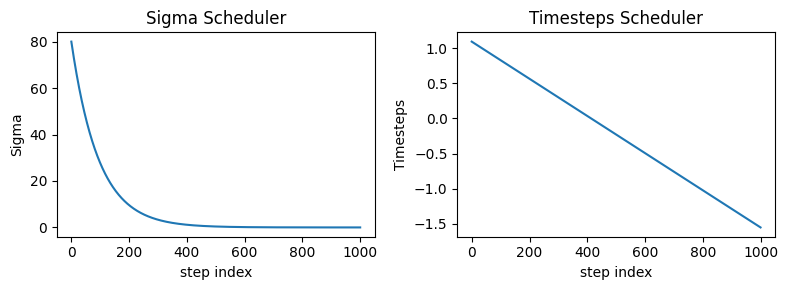

In [76]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(4*2, 3))

axes[0].plot(sigma_scheduler.cpu().numpy())
axes[0].set_xlabel('step index')
axes[0].set_ylabel('Sigma')
axes[0].set_title('Sigma Scheduler')

axes[1].plot(timestep_scheduler.cpu().numpy())
axes[1].set_xlabel('step index')
axes[1].set_ylabel('Timesteps')
axes[1].set_title('Timesteps Scheduler')

fig.tight_layout()

In [77]:
def timestep2stepindex(timestep: float, timestep_schedule: torch.Tensor = timestep_scheduler) -> int:
    indices = (timestep_schedule == timestep).nonzero()
    pos = 1 if len(indices) > 1 else 0
    return indices[pos].item()

In [78]:
timestep2stepindex(timestep_scheduler[5])

5

## 4. Denoise(generation) / Add Noise Utils

ref : https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_edm_euler.py

- Denoise (For Generation)

In [79]:
def precondition_outputs(sample, model_output, sigma, sigma_data: float = 0.5, prediction_type = "epsilon"):
    c_skip = sigma_data**2 / (sigma**2 + sigma_data**2)

    if prediction_type == "epsilon":
        c_out = sigma * sigma_data / (sigma**2 + sigma_data**2) ** 0.5
    elif prediction_type == "v_prediction":
        c_out = -sigma * sigma_data / (sigma**2 + sigma_data**2) ** 0.5
    else:
        raise ValueError(f"Prediction type {prediction_type} is not supported.")

    denoised = c_skip * sample + c_out * model_output

    return denoised

@torch.inference_mode()
def generate(
    denoise_model: nn.Module,
    img_shape: Tuple[int, int, int] = IMG_SHAPE,
    steps: int = STEPS,
    sigma_scheduler: torch.Tensor = sigma_scheduler,
    timestep_scheduler: torch.Tensor = timestep_scheduler,
    s_churn: float = 0.0,
    s_tmin: float = 0.0,
    s_tmax: float = float("inf"),
    s_noise: float = 1.0,
    n_generate: int = 1,
    debug: bool = False,
    device = device,
    return_only_final_image: bool = True,
) -> torch.Tensor:
    denoise_model.eval()
    # create initial pure noise x_tmax
    bs = n_generate
    x_t = init_noise = torch.randn(bs, *img_shape).to(device)
    x_t_list = [x_t] if not return_only_final_image else None

    # for t in timestep_scheduler.cpu().tolist()[::-1]:
    for t in timestep_scheduler.cpu().tolist():
        step_idx = timestep2stepindex(t)
        # predict noise to denoise from x_t
        pred_noise = denoise_model(x_t, torch.tensor([t]).repeat((bs,)).to(device))
        sigma = sigma_scheduler[step_idx]
        gamma = min(s_churn / (len(sigma_scheduler) - 1), 2**0.5 - 1) if s_tmin <= sigma <= s_tmax else 0.0
        sigma_hat = sigma * (gamma + 1)
        if gamma > 0:
            noise = torch.randn_like(
                pred_noise, dtype=pred_noise.dtype, device=pred_noise.device
            )
            eps = noise * s_noise
            x_t = x_t + eps * (sigma_hat**2 - sigma**2) ** 0.5
        # 1. compute predicted original sample (x_0) from sigma-scaled predicted noise
        pred_original_sample = precondition_outputs(x_t, pred_noise, sigma_hat)
        # 2. Convert to an ODE derivative
        derivative = (x_t - pred_original_sample) / sigma_hat
        dt = sigma_scheduler[step_idx + 1] - sigma_hat
        x_prev_t = x_t + derivative * dt
        x_t = x_prev_t

        if not return_only_final_image:
            x_t_list.append(x_t)

    if return_only_final_image:
        x_0 = x_t  # generated image x_0  (n_generate, ch, h, w)
    else:
        x_0 = torch.stack(x_t_list, dim=0)  # (steps, n_generate, ch, h, w)
    return x_0

In [17]:
gen_img = generate(_denoise_model, debug=False)
print(gen_img.shape)

torch.Size([1, 1, 32, 32])


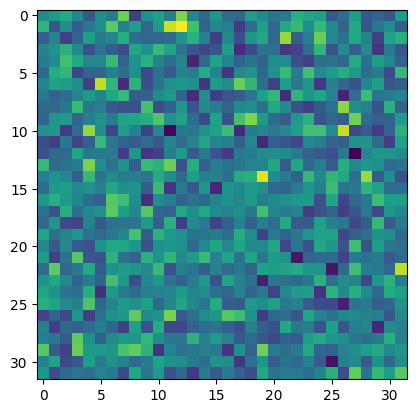

In [18]:
plt.imshow(gen_img[0].cpu().permute(1, 2, 0))

- Add Noise (For Training)

In [91]:
def add_noise(
    x_0: torch.Tensor,
    steps: int = STEPS,
    sigma_scheduler: torch.Tensor = sigma_scheduler,
    timestep_scheduler: torch.Tensor = timestep_scheduler,
    p_mean: float = -0.6,
    p_std: float = 1.2,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Add noise corresponding to random time steps to ground-truth image x_0 to get x_t_rand

    Args:
        x (torch.Tensor): input ground-trueth image x_0 with shape (bs, ch, h, w)

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: noised added image x_t_rand, added noise, random timestepps correponsing to added noise
    """
    bs, ch, h, w = x_0.shape
    random_timesteps = timestep_scheduler[torch.randint(0, len(timestep_scheduler), (bs,))].to(x_0.device)
    step_indices = [timestep2stepindex(t) for t in random_timesteps]

    sigma = sigma_scheduler[step_indices].flatten()
    sigma = sigma.reshape(-1, 1, 1, 1)

    noise = torch.randn_like(x_0)#.to(dtype)
    x_noisy = x_0 + noise * sigma

    return x_noisy, noise, random_timesteps

In [88]:
_x_noisy, _noise, _random_timesteps = add_noise(next(iter(train_dataloader))[0].to(device))
print(_x_noisy.shape, _noise.shape, _random_timesteps.shape)

torch.Size([64, 1, 32, 32]) torch.Size([64, 1, 32, 32]) torch.Size([64])


## 4. Run Training

In [92]:
model = DenoiseModel(
    img_shape=IMG_SHAPE,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

epoch 0 : loss 8.691143035888672


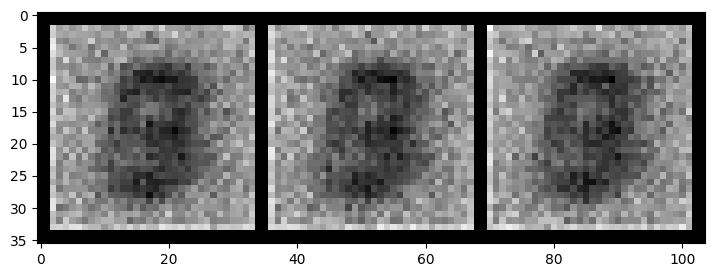

epoch 1 : loss 0.8389133214950562


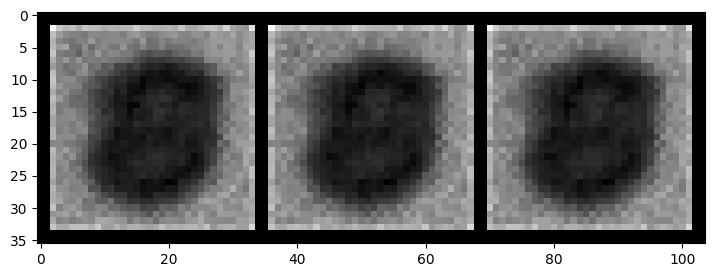

epoch 2 : loss 0.6739930510520935


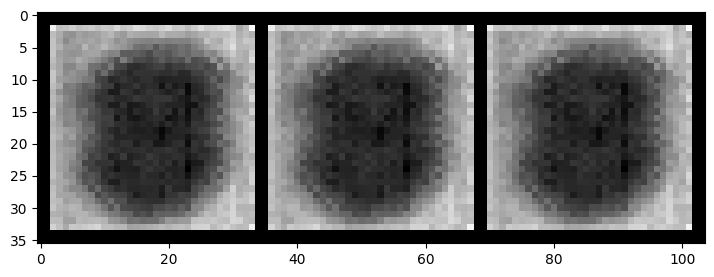

epoch 3 : loss 0.561322808265686


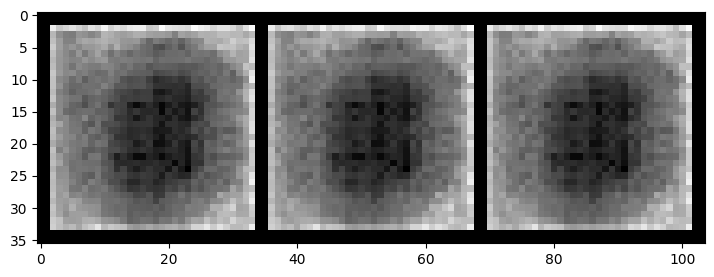

epoch 4 : loss 0.48941901326179504


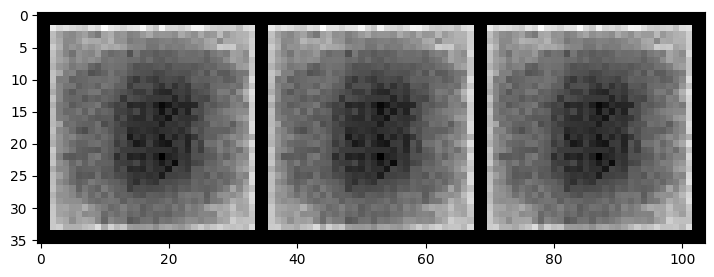

epoch 5 : loss 0.4184890687465668


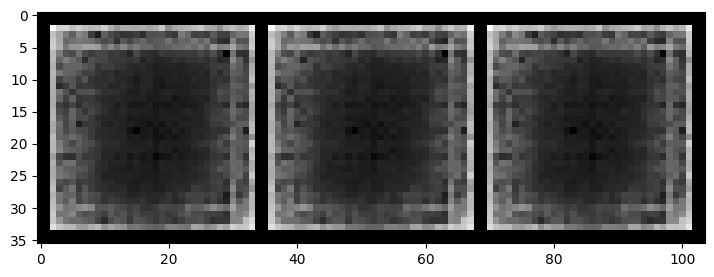

epoch 6 : loss 0.36498185992240906


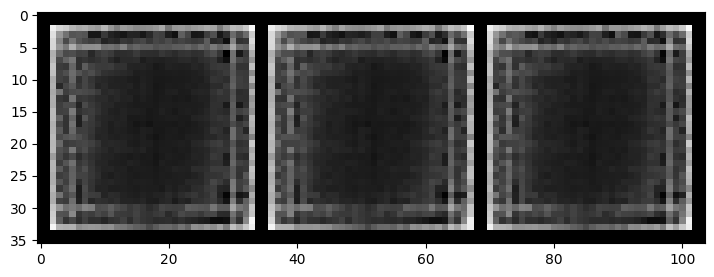

epoch 7 : loss 0.3332725465297699


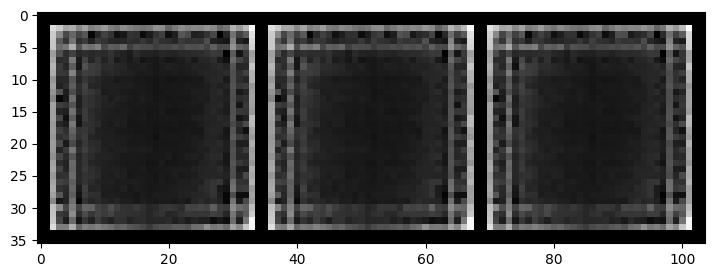

epoch 8 : loss 0.3114435076713562


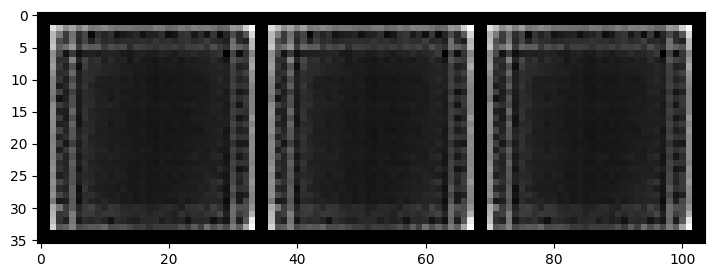

epoch 9 : loss 0.2746973931789398


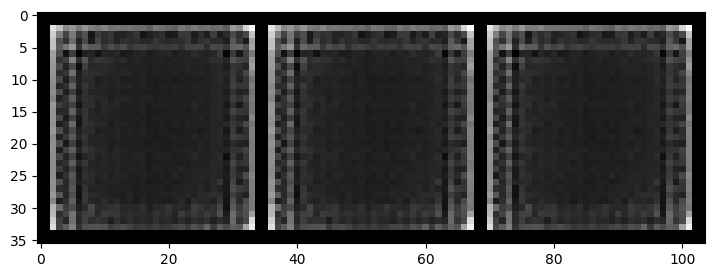

epoch 10 : loss 0.2758614718914032


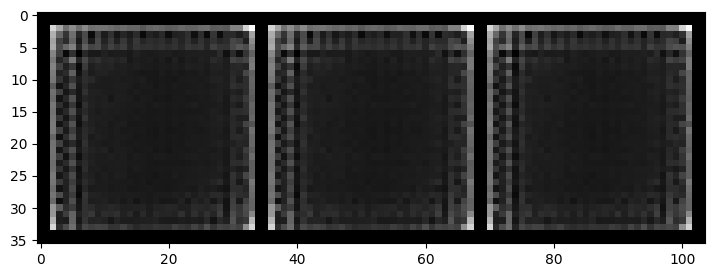

epoch 11 : loss 0.25747808814048767


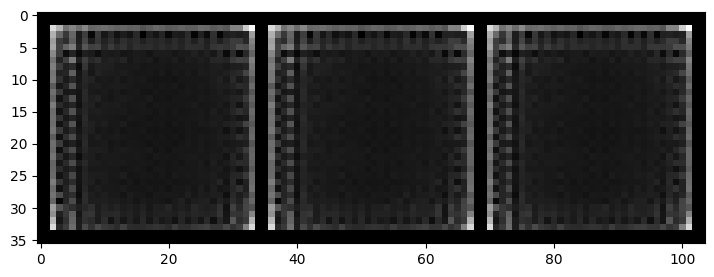

epoch 12 : loss 0.23530352115631104


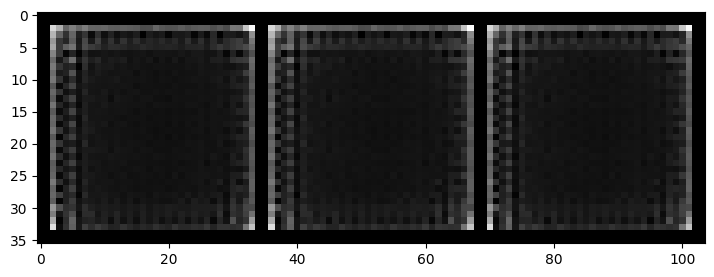

epoch 13 : loss 0.25346970558166504


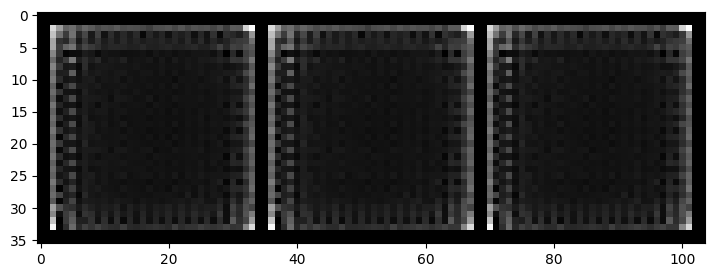

epoch 14 : loss 0.22731998562812805


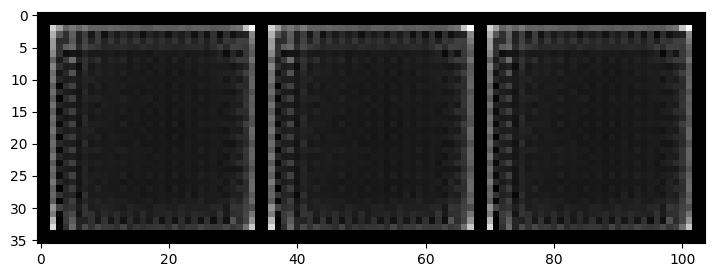

In [93]:
loss_history = []

for epoch in range(EPOCHS):
    # Train phase
    model.train()
    epoch_loss = 0.0
    for (batch_image, batch_class) in pb(train_dataloader):
        optimizer.zero_grad()
        batch_image = batch_image.to(device)
        x_noisy, noise, random_timesteps = add_noise(batch_image, steps=STEPS)  # (bs, ch, h, w), (bs, ch, h, w), (bs,)
        pred_noise = model(x_noisy, random_timesteps)  # (bs, ch, h, w)
        loss = torch.nn.functional.mse_loss(pred_noise.cpu().float(), noise.cpu().float())
        if torch.isnan(loss):
            print('loss is nan')
            break
        loss.backward()
        optimizer.step()
        epoch_loss += loss.cpu().detach()
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]}')

    # Ealuluation Phase
    model.eval()
    gen_img = generate(model, n_generate=3)
    gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())
    grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=3)
    plt.figure(figsize=(3*3, 3))
    plt.imshow(grid_image.permute(1, 2, 0))
    plt.show()

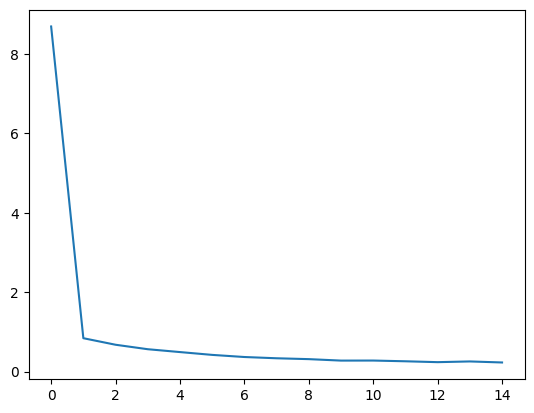

In [94]:
plt.plot(loss_history)

## 5. Generate Images with Trained Model

In [95]:
%%time
gen_img = generate(model, debug=False, n_generate=5*5)

CPU times: user 9.77 s, sys: 14 ms, total: 9.79 s
Wall time: 9.84 s


In [96]:
gen_img = 0.5 * gen_img + 0.5

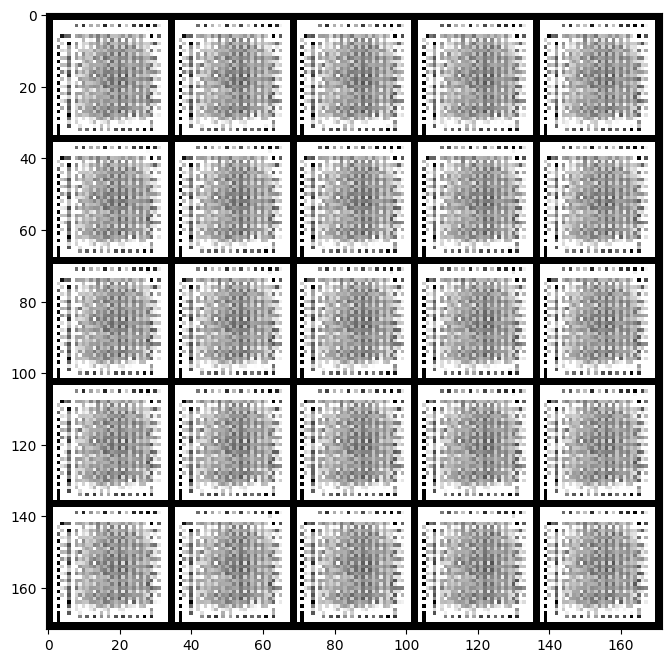

In [97]:
grid_image = torchvision.utils.make_grid(gen_img.cpu(), nrow=5)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))

In [98]:
denoise_elapse_img = generate(model, debug=False, n_generate=1, return_only_final_image=False)

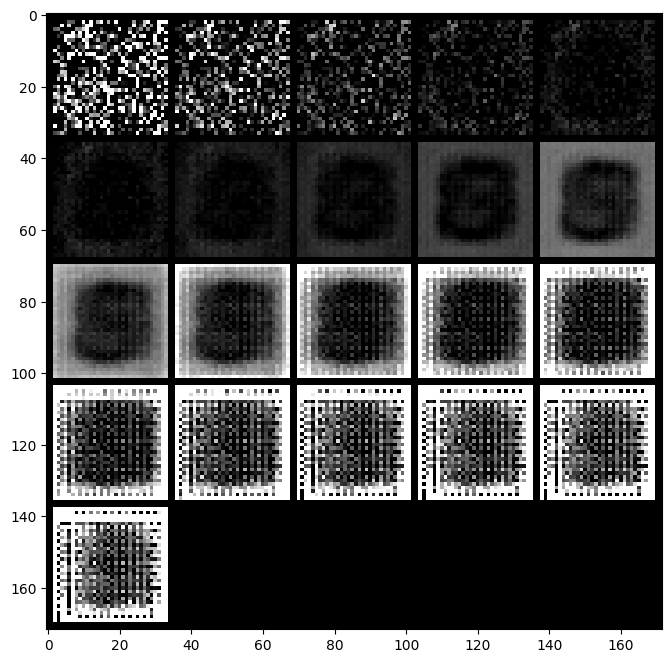

In [99]:
grid_image = torchvision.utils.make_grid(denoise_elapse_img[::50, 0].cpu(), nrow=5)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))